# Лабораторная работа 4

#### Оценка тональности рецензий

## Часть 1. Скраппинг данных

Будем доставать отзывы с Кинопоиска. Для анализа были выбраны фильмы, у которых достаточно и хороших, и плохих отзывов: "Ла-ла-ленд" (2016), "Елки" (2010), "Миллионер из трущоб (2008)" (2023), "Бесславные ублюдки" (2009) и "Оно" (2017). Запиешм их ID в список

In [10]:
ids = [841081, 493768, 413362, 9691, 453397]

Для парсинга будем использовать библиотеку BeautifulSoup4

In [11]:
import requests
from bs4 import BeautifulSoup

Напишем функцию для записи данных в файл.

In [12]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import sleep
import re
import os

In [13]:
def load_user_info(movie_ids: list[int], filename: str):
    #checking if files do not exist or are empty 
    does_exist = (os.path.isfile(filename)) and (not os.stat(filename).st_size == 0)
    if does_exist:
        print(f"File {filename} already exists.")
        return

    #creating the list of rows for our future dataframe
    rows = []
    
    for id in tqdm(movie_ids):
        for target in ['good', 'bad']:
            header = {
                "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36" ,
                'referer':'https://www.google.com/'
            }

            is_no_error = False
            while not is_no_error:
                data = requests.get(f"https://www.kinopoisk.ru/film/{id}/reviews/ord/login/status/{target}/perpage/200/", headers=header)
                soup = BeautifulSoup(data.text)
                if soup.findAll("span", {"itemprop" : "reviewBody"}):
                    is_no_error = True

            title_tag = soup.findAll("title")[0].text
            title = re.sub(" — отзывы и рецензии — Кинопоиск", "", title_tag)

            for tag in soup.findAll("span", {"itemprop" : "reviewBody"}):
                review = tag.text
                rows.append((title, review, target))

            sleep(2)
        
    #creating the dataframe and dumping it to a file
    df = pd.DataFrame.from_dict(rows, orient='columns')
    df.to_csv(filename, index=False)

    return

In [14]:
load_user_info(ids, "reviews.csv")

File reviews.csv already exists.


Выгрузим данные обратно в датфрейм

In [15]:
df = pd.read_csv("reviews.csv", names = ['title', 'review', 'status'], skiprows=1)
print(df.shape)
df.sample(20)

(1407, 3)


,title,review,status
809,Бесславные ублюдки (2009),"Несмотря на то, что фильм Тарантино я посмотре...",good
495,Ёлки (2010),Количество восторженных откликов сразу дало по...,bad
486,Ёлки (2010),"Попытались снять очередную новогоднюю сказку, ...",bad
175,Ла-Ла Ленд (2016),"Прежде всего, Золотой глобус, который получил ...",good
288,Ёлки (2010),"Каждому хочется поверить в чудеса, в какую-то ...",good
746,Миллионер из трущоб (2008),Любителям захватывающих фильмов и остросюжетны...,bad
879,Бесславные ублюдки (2009),"« - Мсье Лападит, а каким прозвищем одарили ме...",good
280,Ёлки (2010),"В том смысле, что хоть не Ж. Фриске, и то хлеб...",good
1267,Оно (2017),В некотором царстве некотором государстве раз ...,good
693,Миллионер из трущоб (2008),"'Миллионер из трущоб' - история о парне, родив...",good


Примерно 30% наших отзывов - отрицательные

In [16]:
df[df["status"] == "bad"].shape[0] / df.shape[0]

0.3091684434968017

## Часть 2. Обучение модели

Для создания модели будем использовать библиотеку `PyTorch`

In [17]:
import torch
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
max_features = 2000

In [20]:
#transformer = TfidfVectorizer(stop_words=stopwords_list, max_features=max_features)
transformer = TfidfVectorizer(max_features=max_features, analyzer="char", ngram_range=(3, 5))
data_vectorized = transformer.fit_transform(df.loc[:, "review"]).todense()
data_vectorized

matrix([[0.07786456, 0.        , 0.01925117, ..., 0.        , 0.01449525,
         0.0137953 ],
        [0.00603736, 0.        , 0.01044871, ..., 0.        , 0.0078674 ,
         0.        ],
        [0.05211138, 0.0122082 , 0.02254695, ..., 0.        , 0.00848841,
         0.00807852],
        ...,
        [0.04830441, 0.        , 0.03715519, ..., 0.        , 0.        ,
         0.01331263],
        [0.04899287, 0.0091821 , 0.02543721, ..., 0.02768322, 0.        ,
         0.02430426],
        [0.0354914 , 0.01662923, 0.        , ..., 0.        , 0.02312475,
         0.        ]])

In [21]:
data_torch = torch.Tensor(data_vectorized)
data_torch

tensor([[0.0779, 0.0000, 0.0193,  ..., 0.0000, 0.0145, 0.0138],
        [0.0060, 0.0000, 0.0104,  ..., 0.0000, 0.0079, 0.0000],
        [0.0521, 0.0122, 0.0225,  ..., 0.0000, 0.0085, 0.0081],
        ...,
        [0.0483, 0.0000, 0.0372,  ..., 0.0000, 0.0000, 0.0133],
        [0.0490, 0.0092, 0.0254,  ..., 0.0277, 0.0000, 0.0243],
        [0.0355, 0.0166, 0.0000,  ..., 0.0000, 0.0231, 0.0000]])

Таким образом, с помощью `TfidfVectorizer` мы представили каждый текст в виде вектора размера 2000, содержащий 2000 наибольших tf-idf для последовательностей символов от 3 до 5.

Создадим и обучим модель

In [22]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
from torch.utils.data import DataLoader

dataset_torch = list(zip(data_torch, (df.loc[:, "status"].to_numpy() == "good").astype("int")))
dataset_torch[0]

(tensor([0.0779, 0.0000, 0.0193,  ..., 0.0000, 0.0145, 0.0138]), 1)

In [24]:
from torch import nn
from torchsummary import summary

'''
model = nn.Sequential(

    nn.Conv1d(in_channels=1, out_channels=4, kernel_size=101), #out size = (4, 900)
    nn.ReLU(),
    nn.MaxPool1d(2), #out size = (4, 450)
    nn.Conv1d(in_channels=4, out_channels=16, kernel_size=11), #out size = (16, 440)
    nn.ReLU(),
    nn.MaxPool1d(2), #out size = (16, 220)
    nn.Flatten(-2),
    nn.Linear(16 * ((max_features-100)//2-10)//2, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 2),
    nn.Softmax(dim=1)

).to(device)
'''
model = nn.Sequential(

    nn.Linear(max_features, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()

).to(device)

summary(model, (1, max_features))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         512,256
              ReLU-2               [-1, 1, 256]               0
            Linear-3                [-1, 1, 64]          16,448
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 16]           1,040
              ReLU-6                [-1, 1, 16]               0
            Linear-7                 [-1, 1, 1]              17
           Sigmoid-8                 [-1, 1, 1]               0
Total params: 529,761
Trainable params: 529,761
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 2.02
Estimated Total Size (MB): 2.03
----------------------------------------------------------------


In [25]:
from torch import optim

optimizer = optim.SGD(model.parameters(), lr=1e-1)
loss_function = nn.BCELoss()

def run(model, dataloader, loss_function, optimizer=None):
    # set the model to evaluation or training mode
    if optimizer == None:
        model.eval()
    else:
        model.train()

    total_loss = 0

    for X, y in dataloader:
        # compute prediction
        pred = model(X[:, None, :].to(device))
        # compute loss
        y = y.to(torch.float32).to(device)
        loss = loss_function(pred[:, 0, 0], y)
        # save loss
        total_loss += loss.item()
        if optimizer != None:
            # compute gradients
            loss.backward()
            # do optimizer step
            optimizer.step()
            # clear gradients
            optimizer.zero_grad()

    return total_loss / len(dataloader)

In [26]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

def show_losses(train_loss_hist, test_loss_hist):
    clear_output()

    plt.figure(figsize=(12,4))

    plt.subplot(1, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Valid Loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.show()

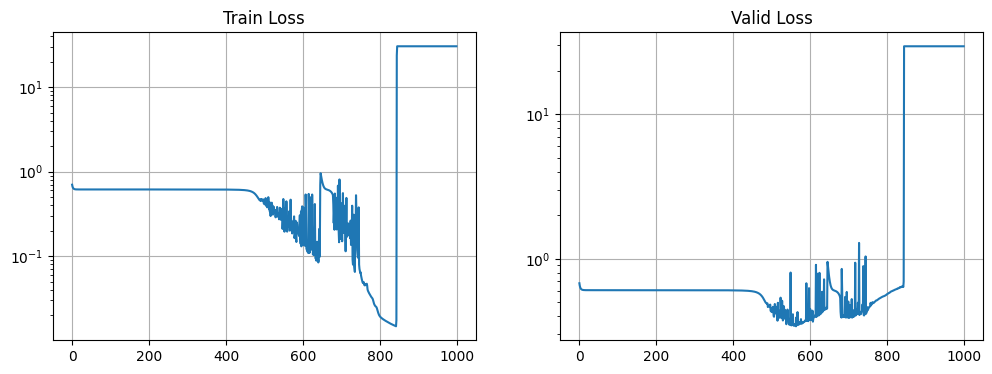

In [27]:
from torch.utils.data import random_split

BATCH_SIZE = 100
NUM_EPOCHS = 1000

train, valid, test = random_split(dataset_torch, [0.6, 0.2, 0.2])
train_loader = DataLoader(train, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE)
test_loader = DataLoader(valid, batch_size=BATCH_SIZE)

train_loss_hist = []
valid_loss_hist = []

for i in range(NUM_EPOCHS):
    train_loss = run(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)
    valid_loss = run(model, valid_loader, loss_function)
    valid_loss_hist.append(valid_loss)

    if i % 100 == 99:
        show_losses(train_loss_hist, valid_loss_hist)


Нейронную сеть обучить адекватно не получилось. Тогда будем использовать обычный градиентный бустинг.

In [28]:
max_features = 5000
transformer = TfidfVectorizer(max_features=max_features, analyzer="char", ngram_range=(3, 5))
data_vectorized = transformer.fit_transform(df.loc[:, "review"]).todense()
data_vectorized

matrix([[0.        , 0.05911139, 0.01456081, ..., 0.        , 0.01490358,
         0.        ],
        [0.        , 0.00490743, 0.        , ..., 0.0083614 , 0.        ,
         0.        ],
        [0.01046522, 0.04418843, 0.02857276, ..., 0.00941116, 0.02924538,
         0.01053865],
        ...,
        [0.        , 0.040522  , 0.00776356, ..., 0.00767137, 0.        ,
         0.00859043],
        [0.        , 0.04119915, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.02575233, 0.02718421, 0.04687369, ..., 0.        , 0.        ,
         0.        ]])

In [159]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

gb = GradientBoostingClassifier(n_estimators=50, max_depth=2)

X_train, X_test, y_train, y_test = train_test_split(data_vectorized, (df.loc[:, "status"].to_numpy() == "good").astype("int"), test_size=0.2, random_state=420)

gb.fit(np.asarray(X_train), y_train)
y_pred = gb.predict(np.asarray(X_test))
y_train_pred = gb.predict(np.asarray(X_train))

print(accuracy_score(y_train_pred, y_train), accuracy_score(y_test, y_pred))

0.9146666666666666 0.851063829787234


Модель выигрывает безхдумный классификатор, который видит все отзывы как положительные, который бы имел `accuracy` 70%. 

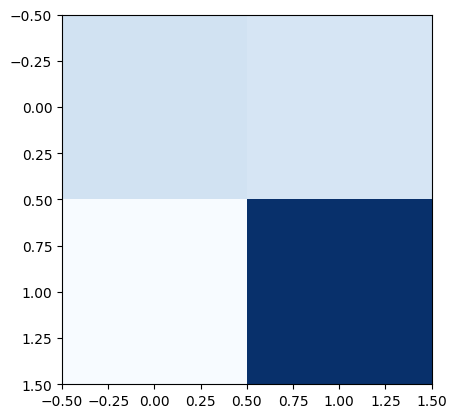

In [160]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test,y_pred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.imshow(cnf_matrix, cmap='Blues')

Видим, что с положительными отзывами модель справляется хорошо, а в отрицательных ошибается примерно в 50% случаев.

## Часть 3. Метрики

[[1.         0.62216611]
 [0.62216611 1.        ]]


(array([  1.,   0.,   1.,   1.,   1.,   8.,  67., 104., 158., 352.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <BarContainer object of 10 artists>)

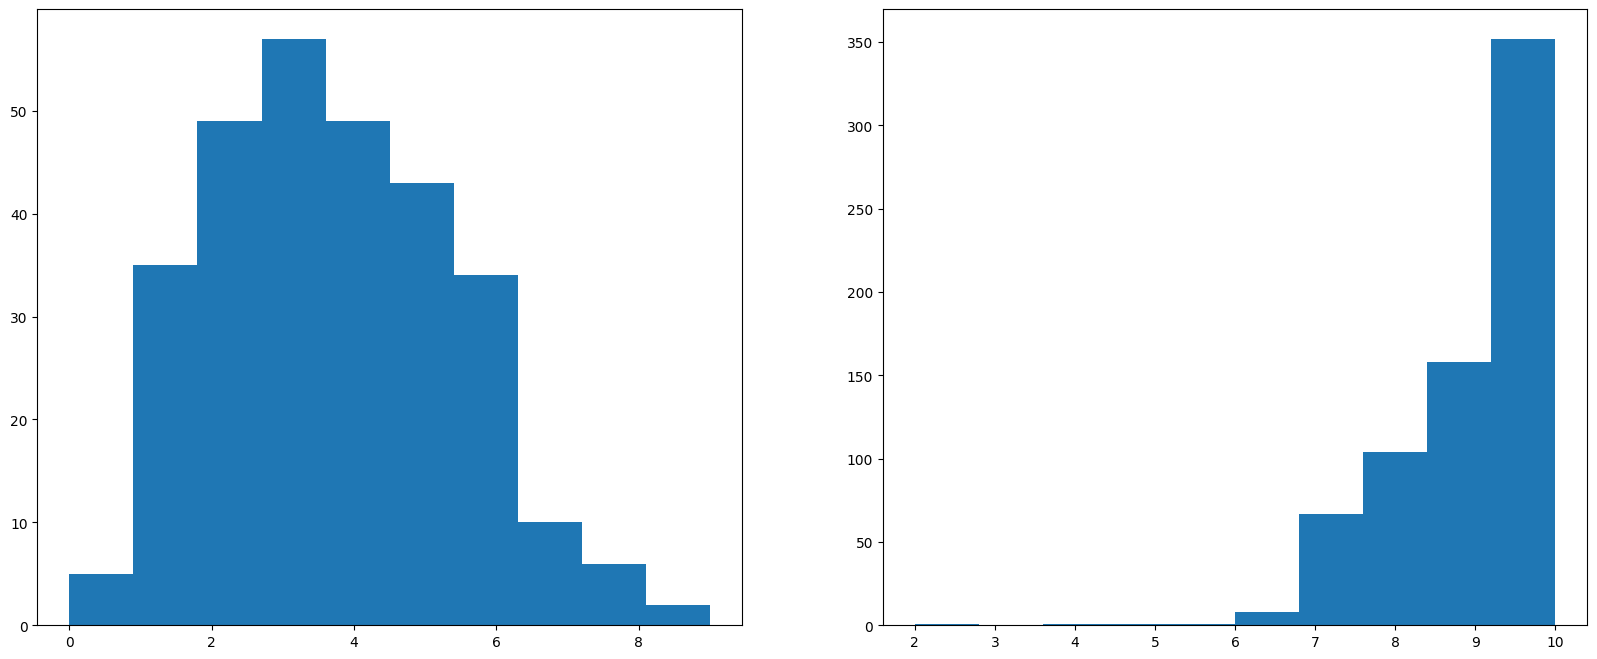

In [161]:
import re
from statistics import mean

ratings = []
statuses = []

for i, text in enumerate(df.loc[:, "review"]):
    matches = re.findall(r"\b([0-9]|10|[0-9].[0-9]) из 10\b", text)
    if matches:
        matches = list(map(lambda x: re.sub(",", ".", x), matches))
        avg_rating = mean(list(map(float, matches)))
        ratings.append(avg_rating)
        statuses.append(int(df.loc[i, "status"] == "good"))

ratings = np.array(ratings)
statuses = np.array(statuses)
print(np.corrcoef(ratings, statuses))
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].hist(ratings[statuses == 0])
axs[1].hist(ratings[(statuses == 1) & (ratings <= 10)])

Видим, что оценки на плохих отзывах распределены около 4, тогда как оценки на положительных отзывах смещены к 10.

In [198]:
X_test_all = []
y_true_all = []
for title in pd.unique(df.loc[:, "title"]):
    X_test_title = []
    y_true_title = []
    for i, _ in enumerate(df[df.loc[:, "title"] == title].loc[:, "title"]):
        if any((np.array(data_vectorized[i]).flatten() == x).all() for x in X_test):
            X_test_title.append(data_vectorized[i])
            y_true_title.append((df.loc[:, "status"].to_numpy() == "good").astype("int")[i])
            X_test_all.append(data_vectorized[i])
            y_true_all.append((df.loc[:, "status"].to_numpy() == "good").astype("int")[i])
    X_test_title = np.squeeze(np.array(X_test_title))
    y_pred = gb.predict(X_test_title)
    print(f"{title}: {accuracy_score(y_true_title, y_pred)}")

X_test_all = np.squeeze(np.array(X_test_all))
y_pred = gb.predict(X_test_all)
print(f"Total: {accuracy_score(y_true_all, y_pred)}")

Ла-Ла Ленд (2016): 0.9
Ёлки (2010): 0.9523809523809523
Миллионер из трущоб (2008): 0.9038461538461539
Бесславные ублюдки (2009): 0.9324324324324325
Оно (2017): 0.9
Total: 0.917910447761194
